## Reddit Sentiment Classification 

## Configurations

Let's first simply use the pretrained model to see baseline performance of LLM.
    
1. Using "__distilbert-base-uncased-finetuned-sst-2-english__"
2. Its finetuned on _SST2_ Dataset (Link - https://huggingface.co/datasets/sst2)
3. Total Number of Params - __67 MN__
4. Class Labels - 0: Negative 1: Positive

## Observations from Result

- To establish the baseline performance in DL approaches we are gonna try in next couple of steps,
- I've took pre trained __DistilBERT__ model from HuggingFace trained on __SST-2 (GLUE)__ dataset for sentiment classification.
- Here I've simply written an evaluation script to test the model on out Reddit Crypto Comments Sentiments.
- It turned out the without any changes, Model yield __~72%__ of _accuracy_.
    - _F1 Score_ for _Negative_ Class: __0.76__ 
    - _F1 Score_ for _Positive_ Class: __0.68__
- For more detail results, please have a look at __Evaluation Results__ Section.

## Importing Common Packages

In [1]:
import pandas as pd
import numpy as np
from collections import Collection
import re,string,unicodedata
import contractions
import html

C:\Users\darsh\AppData\Local\Temp\ipykernel_29212\894766657.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Collection


In [2]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

## Utility Functions

In [3]:
def plot_confusion_matrix(test_y, predict_y):
    C = metrics.confusion_matrix(test_y, predict_y)
    missclassified_pts = (len(test_y)-np.trace(C))/len(test_y)*100
    print("Number of misclassified points -",np.round(missclassified_pts, 2),"%")
    # C = 2,2 matrix, each cell (i,j) represents number of points of class i are predicted class j
    # The predictions are along the columns of the confusion matrix whereas the actual values are along the rows of confusion matrix.
    
    A =(((C.T)/(C.sum(axis=1))).T)
        
    B =(C/C.sum(axis=0))
        
    labels = [0,1]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    #print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(20,4))
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    #plt.show()

    #print("-"*50, "Precision matrix", "-"*50)
    #plt.figure(figsize=(10,5))
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    #plt.show()
    #print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    #print("-"*50, "Recall matrix"    , "-"*50)
    #plt.figure(figsize=(10,5))
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    #plt.show()
    #print("Sum of rows in Recall matrix",A.sum(axis=1))

## Minimal Data PreProcessing

In [4]:
data_df = pd.read_csv("../data/crypto_reddit_sentiment.csv")
data_df

,worker_id,is_reviewed,review_score,Comment Text,Sentiment,Reddit URL
0,XYNN2Y4VCF3G,False,NaN,"I bought 2200 at the ico, at 0.50$ per coin. H...",Positive,https://www.reddit.com/r/Avax/comments/uzggar/...
1,DR6XNZMT9KRH,False,NaN,"Harmony one , algorand , Cardano, solana , vec...",Positive,https://www.reddit.com/r/CryptoCurrency/commen...
2,9FCQGMYD4A42,False,NaN,"Honestly, after reading this post and many of ...",Negative,https://www.reddit.com/r/CryptoCurrency/commen...
3,QEZAEMV2WF9D,False,NaN,In bear market is where money is made. I Will ...,Positive,https://www.reddit.com/r/CryptoCurrency/commen...
4,Z7J7W3XCP4XC,False,NaN,Funny how people think Bitcoin's risk is compa...,Negative,https://www.reddit.com/r/investing/comments/um...
...,...,...,...,...,...,...
557,FM9FYY27VTVR,False,NaN,Lightning Network has the capability to do mil...,Positive,https://www.reddit.com/r/Bitcoin/comments/uzz7...
558,K94W3ATCZX2V,False,NaN,It means there will be more daily volume which...,Positive,https://www.reddit.com/r/Bitcoin/comments/v0fs...
559,W7APN9XYDRV6,False,NaN,The exchanges were so irresponsible to list th...,Negative,https://www.reddit.com/r/CryptoCurrency/commen...
560,MTCJYTYKKHZJ,False,NaN,Massive ecosystem. Pretty much all application...,Positive,https://www.reddit.com/r/CryptoCurrency/commen...


In [5]:
data_df.rename(columns={"Comment Text": "text", "Sentiment": "sentiment"}, inplace=True)
data_df = data_df[["text", "sentiment"]].copy(deep=True)
data_df["sentiment"] = data_df["sentiment"].apply(lambda x: x.upper())
data_df['class'] = np.where(data_df["sentiment"] == "NEGATIVE", 0, 1)
data_df

,text,sentiment,class
0,"I bought 2200 at the ico, at 0.50$ per coin. H...",POSITIVE,1
1,"Harmony one , algorand , Cardano, solana , vec...",POSITIVE,1
2,"Honestly, after reading this post and many of ...",NEGATIVE,0
3,In bear market is where money is made. I Will ...,POSITIVE,1
4,Funny how people think Bitcoin's risk is compa...,NEGATIVE,0
...,...,...,...
557,Lightning Network has the capability to do mil...,POSITIVE,1
558,It means there will be more daily volume which...,POSITIVE,1
559,The exchanges were so irresponsible to list th...,NEGATIVE,0
560,Massive ecosystem. Pretty much all application...,POSITIVE,1


In [6]:
def lower_case(text):
    return text.lower()

In [7]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [8]:
def remove_urls(text):
    return re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)

In [9]:
def fix_html(x:str) -> str:
    "List of replacements from html strings in `x`."
    re1 = re.compile(r'  +')
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', "UNK").replace(' @.@ ','.').replace(
        ' @-@ ','-').replace(' @,@ ',',').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [10]:
def remove_extra_lines(text):
    return re.sub(r'\n|\r|\t', ' ', text)

In [11]:
def remove_useless_spaces(t:str) -> str:
    "Remove multiple spaces in `t`."
    return re.sub(' {2,}', ' ', t)

In [12]:
def replace_rep(t:str) -> str:
    "Replace repetitions at the character level in `t`."
    def _replace_rep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {"TK_REP"} {len(cc)+1} {c} '
    re_rep = re.compile(r'(\S)(\1{3,})')
    return re_rep.sub(_replace_rep, t)

In [13]:
#Function to expand contractions
def expand_contractions(con_text):
    con_text = contractions.fix(con_text)
    return con_text

In [14]:
data_df["processed_text"] = data_df["text"].astype(str).apply(lambda text: lower_case(text))
# data_df["processed_text"] = data_df["processed_text"].apply(lambda text: remove_accented_chars(text))
data_df["processed_text"] = data_df["processed_text"].apply(lambda text: remove_urls(text))
data_df["processed_text"] = data_df["processed_text"].apply(lambda text: fix_html(text))
data_df["processed_text"] = data_df["processed_text"].apply(lambda text: remove_extra_lines(text))
data_df["processed_text"] = data_df["processed_text"].apply(lambda text: remove_useless_spaces(text))
data_df["processed_text"] = data_df["processed_text"].apply(lambda text: replace_rep(text))
data_df["processed_text"] = data_df["processed_text"].apply(lambda text: expand_contractions(text))
data_df = data_df.filter(["sentiment", "class", "text", "processed_text"])
data_df

,sentiment,class,text,processed_text
0,POSITIVE,1,"I bought 2200 at the ico, at 0.50$ per coin. H...","i bought 2200 at the ico, at 0.50$ per coin. h..."
1,POSITIVE,1,"Harmony one , algorand , Cardano, solana , vec...","harmony one , algorand , cardano, solana , vec..."
2,NEGATIVE,0,"Honestly, after reading this post and many of ...","honestly, after reading this post and many of ..."
3,POSITIVE,1,In bear market is where money is made. I Will ...,in bear market is where money is made. i will ...
4,NEGATIVE,0,Funny how people think Bitcoin's risk is compa...,funny how people think bitcoin's risk is compa...
...,...,...,...,...
557,POSITIVE,1,Lightning Network has the capability to do mil...,lightning network has the capability to do mil...
558,POSITIVE,1,It means there will be more daily volume which...,it means there will be more daily volume which...
559,NEGATIVE,0,The exchanges were so irresponsible to list th...,the exchanges were so irresponsible to list th...
560,POSITIVE,1,Massive ecosystem. Pretty much all application...,massive ecosystem. pretty much all application...


In [16]:
data_df["processed_text"][100]

'axie will fail because it is just a mediocre game coin and there are far more game companies that make better games. mana because have you actually experienced decentraland? it is buggy and there are better tech companies that can create so much better stable metaverse than mana. '

In [17]:
data_df['sentiment'].value_counts()

POSITIVE    302
NEGATIVE    260
Name: sentiment, dtype: int64

## Importing HF Packages

In [18]:
import torch
import torch.nn.functional as F
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torchsummary import summary

In [19]:
import datasets
from datasets import Dataset, DatasetDict

In [20]:
from torch.utils.data import DataLoader
import evaluate

## Defining Model Checkpoint Name From HF

In [21]:
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"

## Preparing HF Dataset

### Loading

In [22]:
reddit_ds = Dataset.from_pandas(data_df)
reddit_ds

Dataset({
    features: ['sentiment', 'class', 'text', 'processed_text'],
    num_rows: 562
})

In [23]:
reddit_ds = reddit_ds.rename_column("class", "labels")
reddit_ds

Dataset({
    features: ['sentiment', 'labels', 'text', 'processed_text'],
    num_rows: 562
})

### Tokenizing

In [24]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [25]:
def tokenize_function(examples):
    return tokenizer(examples["processed_text"], padding="max_length", truncation=True, return_tensors="pt")

In [26]:
tokenized_reddit_ds = reddit_ds.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [27]:
tokenized_reddit_ds

Dataset({
    features: ['sentiment', 'labels', 'text', 'processed_text', 'input_ids', 'attention_mask'],
    num_rows: 562
})

In [28]:
tokenized_mini_reddit_ds = tokenized_reddit_ds.remove_columns(["sentiment", "text", "processed_text"])
tokenized_mini_reddit_ds

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 562
})

In [29]:
tokenized_mini_reddit_ds.set_format("torch")
tokenized_mini_reddit_ds

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 562
})

### Defining DataLoader for efficient Batching

In [30]:
reddit_dataloader = DataLoader(tokenized_mini_reddit_ds, batch_size=64)

## Defining Evaluation Metrics

In [31]:
metric = evaluate.combine(["accuracy", "precision", "recall", "f1"])

## Loading HF Model

In [32]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [33]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [34]:
model.to(device)
summary(model)

Layer (type:depth-idx)                        Param #
├─DistilBertModel: 1-1                        --
|    └─Embeddings: 2-1                        --
|    |    └─Embedding: 3-1                    23,440,896
|    |    └─Embedding: 3-2                    393,216
|    |    └─LayerNorm: 3-3                    1,536
|    |    └─Dropout: 3-4                      --
|    └─Transformer: 2-2                       --
|    |    └─ModuleList: 3-5                   42,527,232
├─Linear: 1-2                                 590,592
├─Linear: 1-3                                 1,538
├─Dropout: 1-4                                --
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0


Layer (type:depth-idx)                        Param #
├─DistilBertModel: 1-1                        --
|    └─Embeddings: 2-1                        --
|    |    └─Embedding: 3-1                    23,440,896
|    |    └─Embedding: 3-2                    393,216
|    |    └─LayerNorm: 3-3                    1,536
|    |    └─Dropout: 3-4                      --
|    └─Transformer: 2-2                       --
|    |    └─ModuleList: 3-5                   42,527,232
├─Linear: 1-2                                 590,592
├─Linear: 1-3                                 1,538
├─Dropout: 1-4                                --
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0

## Evaluation Loop

In [35]:
%%time

y_preds = []
y_trues = []

model.eval()
for batch in reddit_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions = F.softmax(logits, dim=1)
    y_pred = torch.argmax(predictions, dim=-1)
    metric.add_batch(predictions=y_pred, references=batch["labels"])
    y_preds.extend(y_pred.cpu().numpy())
    y_trues.extend(batch["labels"].cpu().numpy())
    
metric.compute()

CPU times: total: 6.47 s
Wall time: 6.63 s


{'accuracy': 0.7241992882562278,
 'precision': 0.8888888888888888,
 'recall': 0.5562913907284768,
 'f1': 0.6843177189409368}

## Evaluation Results

### Classification Report -SkLearn

In [36]:
cls_report = metrics.classification_report(y_true=y_trues, y_pred=y_preds)
print(cls_report)

              precision    recall  f1-score   support

           0       0.64      0.92      0.76       260
           1       0.89      0.56      0.68       302

    accuracy                           0.72       562
   macro avg       0.76      0.74      0.72       562
weighted avg       0.77      0.72      0.72       562



### Confusion Matrix - SkLearn

Number of misclassified points - 27.58 %


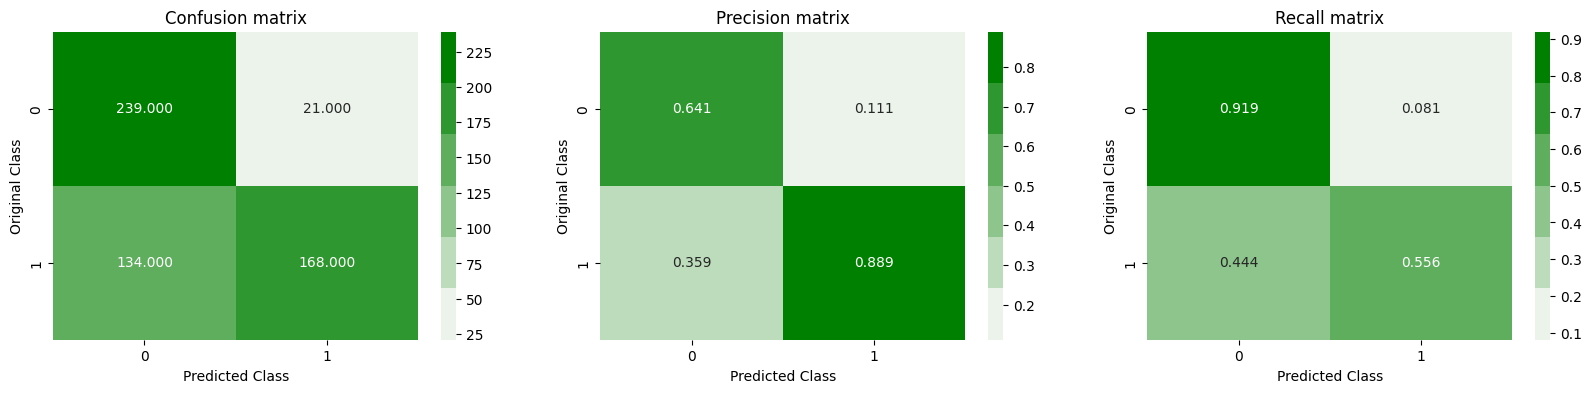

In [37]:
plot_confusion_matrix(test_y=y_trues, predict_y=y_preds)

## Misc